In [85]:
#importing all the important libraries
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns

In [86]:
#pd.read_excel is used for reading excel file only
data = pd.read_excel( "sales_data.xlsx" )
data.head()

,CustomerID,TOTAL_ORDERS,REVENUE,AVERAGE_ORDER_VALUE,CARRIAGE_REVENUE,AVERAGESHIPPING,FIRST_ORDER_DATE,LATEST_ORDER_DATE,AVGDAYSBETWEENORDERS,DAYSSINCELASTORDER,...,TIME_0000_0600_ORDERS,TIME_0601_1200_ORDERS,TIME_1200_1800_ORDERS,TIME_1801_2359_ORDERS,TIME_0000_0600_REVENUE,TIME_0601_1200_REVENUE,TIME_1200_1800_REVENUE,TIME_1801_2359_REVENUE,Unnamed: 40,Unnamed: 41
0,22,124,11986.54,96.67,529.59,4.27,2016-12-30,2021-10-24,14.19,1,...,12,61,37,14,1067.92,5674.65,3916.53,1327.44,NaN,NaN
1,29,82,11025.96,134.46,97.92,1.19,2018-03-31,2021-10-24,15.89,1,...,1,13,24,44,30.25,3143.69,2205.47,5646.55,NaN,33340.77
2,83,43,7259.69,168.83,171.69,3.99,2017-11-30,2021-10-24,33.12,1,...,0,6,12,25,0.00,707.98,2560.91,3990.80,NaN,NaN
3,95,44,6992.27,158.92,92.82,2.11,2019-04-09,2021-10-24,21.11,1,...,0,10,13,21,0.00,1908.99,2025.05,3058.23,NaN,NaN
4,124,55,6263.44,113.88,179.04,3.26,2020-10-23,2021-10-24,6.65,1,...,6,9,27,13,501.34,1197.83,3004.77,1559.50,NaN,NaN


In [87]:
#this table tells about the customerID
User_info = pd.DataFrame(data["CustomerID"].unique())
User_info.columns = ["CustomerID"]
User_info.head()

,CustomerID
0,22
1,29
2,83
3,95
4,124


In [88]:
#merge is used for the concatenate of two table
User_info=pd.merge(User_info,data[["CustomerID","DAYSSINCELASTORDER"]],on="CustomerID")
User_info.head()

,CustomerID,DAYSSINCELASTORDER
0,22,1
1,29,1
2,83,1
3,95,1
4,124,1


In [89]:
#DAYSSINCELASTORDER is very big name so we have to rename it or you can used same also
User_info.rename(columns = {'DAYSSINCELASTORDER':'Recency'}, inplace = True)
User_info.head()

,CustomerID,Recency
0,22,1
1,29,1
2,83,1
3,95,1
4,124,1


In [90]:
#segregrating Dlast_order value into 4 clusters 
#here we are importing Kmeans algorithm
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
User_info['RecencyCluster'] = kmeans.fit_predict(User_info[['Recency']])

In [91]:
User_info.head()

,CustomerID,Recency,RecencyCluster
0,22,1,1
1,29,1,1
2,83,1,1
3,95,1,1
4,124,1,1


In [92]:
#Ordering clusters We have a cluster corresponding to each customerID. But each cluster is randomly assigned.
# We will give indices to these clusters as 0,1,2,3.
# Now we will drop the original cluster numbers and replace them with 0,1,2,3.
def order_cluster(cluster_field_name, target_field_name,data,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    data_new = data_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    data_new['index'] = data_new.index
    data_final = pd.merge(data,data_new[[cluster_field_name,'index']], on=cluster_field_name)
    data_final = data_final.drop([cluster_field_name],axis=1)
    data_final = data_final.rename(columns={"index":cluster_field_name})
    return data_final
User_info = order_cluster('RecencyCluster', 'Recency',User_info,False)

In [93]:
User_info.head()

,CustomerID,Recency,RecencyCluster
0,22,1,3
1,29,1,3
2,83,1,3
3,95,1,3
4,124,1,3


In [94]:
#To create frequency clusters, we need to find total number orders for each customer
Frequency = data.groupby('CustomerID').TOTAL_ORDERS.count().reset_index()
Frequency .columns = ['CustomerID','Frequency']

In [95]:
#here we used merge to concatenate two table
User_info = pd.merge(User_info, Frequency , on='CustomerID')
User_info.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,22,1,3,1
1,29,1,3,1
2,83,1,3,1
3,95,1,3,1
4,124,1,3,1


In [96]:
#here we are creating 4 clusters 
kmeans=KMeans(n_clusters=4)
User_info['Frequency_Cluster']=kmeans.fit_predict(User_info[['Frequency']])
User_info = order_cluster('Frequency_Cluster', 'Frequency',User_info, True )
User_info.head()

C:\Users\anand\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


,CustomerID,Recency,RecencyCluster,Frequency,Frequency_Cluster
0,22,1,3,1,0
1,29,1,3,1,0
2,83,1,3,1,0
3,95,1,3,1,0
4,124,1,3,1,0


In [97]:
#We will calculate revenue for each customer
revenue_by_each = data.groupby('CustomerID').REVENUE.sum().reset_index()

In [98]:
User_info = pd.merge(User_info, revenue_by_each, on='CustomerID')
User_info.head()

,CustomerID,Recency,RecencyCluster,Frequency,Frequency_Cluster,REVENUE
0,22,1,3,1,0,11986.54
1,29,1,3,1,0,11025.96
2,83,1,3,1,0,7259.69
3,95,1,3,1,0,6992.27
4,124,1,3,1,0,6263.44


In [99]:
#info tells about the datatype of an attributes
User_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         5000 non-null   int64  
 1   Recency            5000 non-null   int64  
 2   RecencyCluster     5000 non-null   int64  
 3   Frequency          5000 non-null   int64  
 4   Frequency_Cluster  5000 non-null   int64  
 5   REVENUE            5000 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 273.4 KB


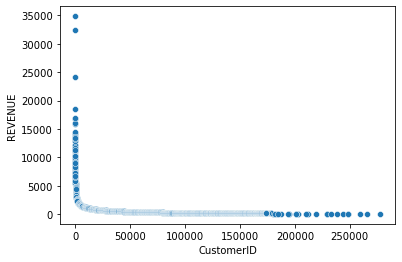

In [100]:
#this graph tells about the CustomeID vs Revenue
#also tells about which CustomeID generate more revenue
sns.scatterplot(data=User_info,x="CustomerID",y="REVENUE")

In [101]:
kmeans = KMeans(n_clusters=4)
User_info['Revenue_Cluster'] = kmeans.fit_predict(User_info[['REVENUE']])
User_info = order_cluster('Revenue_Cluster', 'REVENUE',User_info,True)

In [102]:
#calculate overall score and use mean() to see total details
User_info['Score'] = User_info['RecencyCluster'] + User_info['Frequency_Cluster'] + User_info['Revenue_Cluster']
User_info.groupby('Score')['Recency','Frequency','REVENUE'].mean()

C:\Users\anand\AppData\Local\Temp/ipykernel_3912/3743466488.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  User_info.groupby('Score')['Recency','Frequency','REVENUE'].mean()


,Recency,Frequency,REVENUE
Score,,,
0,203.379693,1.0,382.644198
1,139.048780,1.0,1255.096679
2,95.434328,1.0,1872.306821
3,24.002885,1.0,1404.334778
4,22.471154,1.0,3341.402624
5,16.849673,1.0,6666.875752
6,13.727273,1.0,13587.530000


In [103]:
#here we are creating a level colmn for identify on the basic of high and low
User_info['level'] = 'low'
User_info.loc[User_info['Score']>2,'level'] = 'Mid' 
User_info.loc[User_info['Score']>4,'level'] = 'High' 

In [104]:
User_info

,CustomerID,Recency,RecencyCluster,Frequency,Frequency_Cluster,REVENUE,Revenue_Cluster,Score,level
0,22,1,3,1,0,11986.54,3,6,High
1,29,1,3,1,0,11025.96,3,6,High
2,4,5,3,1,0,18554.49,3,6,High
3,17,6,3,1,0,12969.98,3,6,High
4,10,13,3,1,0,14309.92,3,6,High
...,...,...,...,...,...,...,...,...,...
4995,173946,207,0,1,0,117.49,0,0,low
4996,173987,207,0,1,0,117.49,0,0,low
4997,174004,207,0,1,0,117.49,0,0,low
4998,174038,207,0,1,0,117.49,0,0,low


In [105]:
#max function used for give maximum value
data['DAYSSINCELASTORDER'].max()

207

In [106]:
#min function used for give minimun value
data['DAYSSINCELASTORDER'].min()

1

In [107]:
User_info['Recency'].max()

207

In [108]:
User_info['Recency'].min()

1

In [109]:
# We can start taking actions with this segmentation. The main strategies are we have to figure out some of the term:-
# High Value: Improve Retention
# Mid Value: Improve Retention + Increase Frequency
# Low Value: Increase Frequency+improve retention

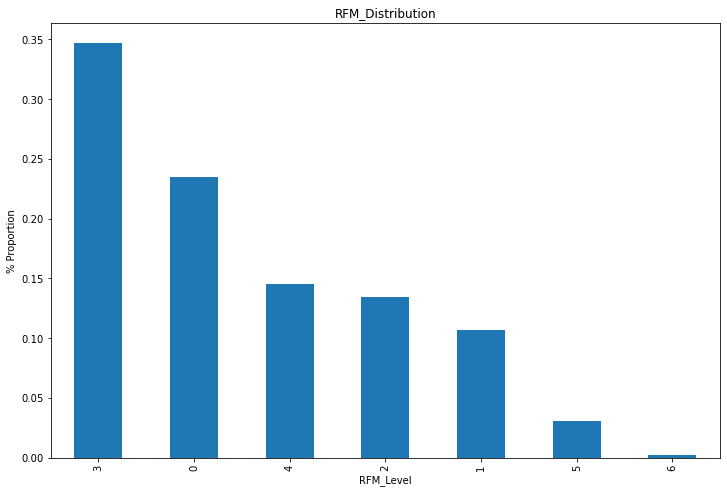

In [110]:
#here we are creating a RMF graph to analysis of the customer Segmentation 
plt.figure(figsize=(12,8))
User_info['Score'].value_counts(normalize = True).plot(kind='bar')
plt.title('RFM_Distribution')
plt.xlabel('RFM_Level')
plt.ylabel('% Proportion')
plt.show()

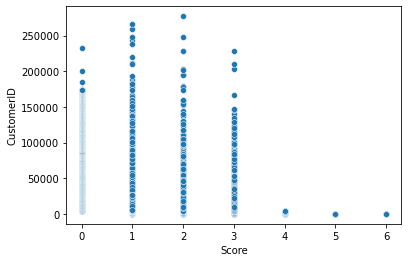

In [111]:
#this graph tells about the score vs CustomerID
sns.scatterplot(data=User_info, x="Score",y="CustomerID")

In [112]:
#days since last order can be calculated by
purchase = data.groupby('CustomerID').LATEST_ORDER_DATE.max().reset_index()
purchase.columns = ['CustomerID','Max_date_purchase']
purchase.head()

,CustomerID,Max_date_purchase
0,1,2021-09-02
1,2,2021-07-23
2,3,2021-09-02
3,4,2021-10-20
4,5,2021-06-17


In [113]:
#here we are calculating the purchase rate.
purchase['Recency'] = (purchase['Max_date_purchase'].max() - purchase['Max_date_purchase']).dt.days
purchase.head()

,CustomerID,Max_date_purchase,Recency
0,1,2021-09-02,52
1,2,2021-07-23,93
2,3,2021-09-02,52
3,4,2021-10-20,4
4,5,2021-06-17,129


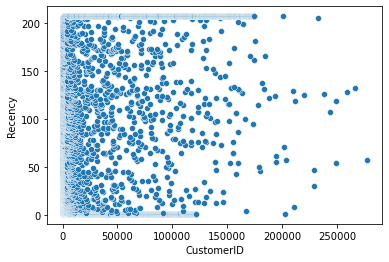

In [114]:
#this graph tells about the CustomerID vs Days last order(Dlast_order)
sns.scatterplot(data=User_info, x="CustomerID",y="Recency")